# L1 - Градиентый спуск и линейные модели

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import math

get_ipython().magic('matplotlib notebook')
matplotlib.rcParams['figure.figsize'] = '12,8'
matplotlib.rcParams['figure.max_open_warning'] = False

In [2]:
def setup_plot_figure(xlabel='x', ylabel='y', hline=False, vline=False, equal_axes=False):
    f = plt.figure()
    if equal_axes:
        plt.axis('equal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, which='both')
    if hline:
        plt.axhline(color='k', alpha=0.7)
    if vline:
        plt.axvline(color='k', alpha=0.7)
    return f

<IPython.core.display.Javascript object>


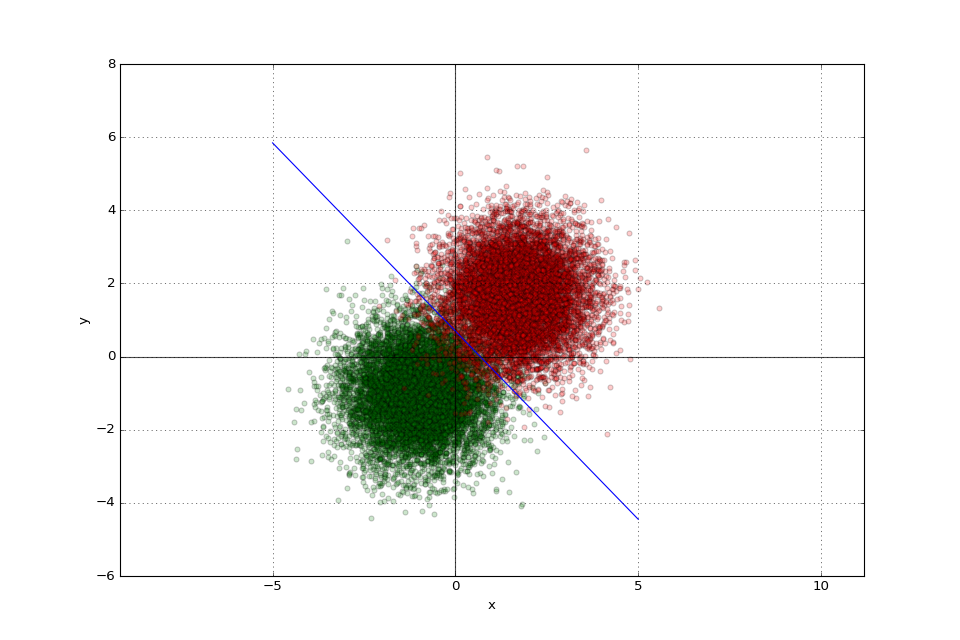

In [14]:
SAMPLE_NUM = 10000

positive_class_features = np.random.normal(-1, 1, (SAMPLE_NUM, 2))
negative_class_features = np.random.normal(1.7, 1, (SAMPLE_NUM, 2))

X = np.c_[np.ones(SAMPLE_NUM * 2), np.concatenate((positive_class_features, negative_class_features))]
Y = np.r_[np.ones(SAMPLE_NUM), -np.ones(SAMPLE_NUM)].reshape(SAMPLE_NUM * 2)

w_exact = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

x_ax = np.linspace(-5, 5, 2)
y_ax_exact = np.array(-(w_exact[0] + w_exact[1] * x_ax) / w_exact[2])

setup_plot_figure(hline=True, vline=True, equal_axes=True)
plt.scatter(positive_class_features[:, 0], positive_class_features[:, 1], c='green', alpha=0.2)
plt.scatter(negative_class_features[:, 0], negative_class_features[:, 1], c='red', alpha=0.2)
plt.plot(x_ax, y_ax_exact, color='b')
plt.show()

Две матрицы размеров $a\times b$ и $b \times c$ перемножаются за $O(abc)$ операций ($a\cdot c$ ячеек в новой таблице, на получение каждой требуется $b$ операций), матрица $a \times a$ оборачивается за $O(a^3)$ операций, $a \times b$ транспонируется за $O(ab)$. Зная это, а также считая, что входная выборка имеет размер $n$ и $m$ параметров, получаем следующую асимптотику за счёт выполнения последовательно пяти операций: транспонирования матрицы $X$ умножения матриц $X_{m\times n}^T$ и $X_{n\times m}$, обращения получившейся матрицы $m\times m$, умножения обращённой матрицы $m\times m$ и $X_{m\times n}^T$ и умножения матриц $m\times n$ и $Y_{n \times 1}$. Тогда
$$O(m\cdot n)+O(m\cdot n \cdot m)+O(m^3)+O(m\cdot m \cdot n)+O(m\cdot n)=O(m^2n)+O(m^3).$$ Если считать, что $m<n$, то можно упростить выражение до $O(m^2n)$.

**Задание**

1. Пусть $\mathbb{P}\{y=1|x\} = \sigma(wx+b)$, где $\sigma(z) = \frac{1}{1 + \exp(-z)}$. Покажите, что задача
$$ \arg\min_{w, b} \sum_{x, y} \ln(1 + \exp(-y(wx + b)))$$
есть не что иное, как максимизация правдоподобия.
2. Отобразите все функционалы качества в осях $M \times Q$ для одного элемента.


1. Функция правдоподобия: $\mathbb{P}\{y|x\}=\sigma(y(wx+b))$. Если считать совпадения предсказанных классов для элементов выборки с актуальными классами независимыми в совокупности событиями, то можно переписать $\mathbb{P}\{y|x\}$ как $\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}$. Максимизация функции правдоподобия тогда представляется как задача $$\underset{w}{\mathrm{argmax}}\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}=\underset{w}{\mathrm{argmax}}\ln\prod_{i=0}^n\mathbb{P}\{y_i|x_i\}=$$ (исходя из монотонности логарифма, если функция в данной точке имеет максимум, то и её логарифм)$$=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln\mathbb{P}\{y_i|x_i\}=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln\sigma(y_i(wx_i+b))=\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})^{-1}=$$(по свойству логарифма)$$=-\underset{w}{\mathrm{argmax}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})=\underset{w}{\mathrm{argmin}}\sum_{i=0}^n\ln(1+e^{-y(wx+b)})$$

2. Так как $ M(x, y) = y\cdot(wx)$ (можно добавить первую компоненту к $x$, равную $1$ и к $w$, равную $b$ и получить исходное равенство), получаем следующие зависимости $Q$ от $M$:

    1) $Q = [y_{pred} \neq y_{true}]=[y\cdot(wx)<0]=[M < 0]$
    
    2) $Q = ((wx) - y)^{2}=\frac{1}{y^2}((wx\cdot y) - y^2)^2=\frac{1}{y^2}(M - y^2)^2$. Так как $y=\pm 1$, то $Q=(M - 1)^2$.
    
    3) $Q = max(0, 1 - y\cdot(wx))=max(0,1-M)$
    
    4) $Q = \ln(1 + e^{-y\cdot(wx)})=\ln(1+e^{-M})$

<IPython.core.display.Javascript object>


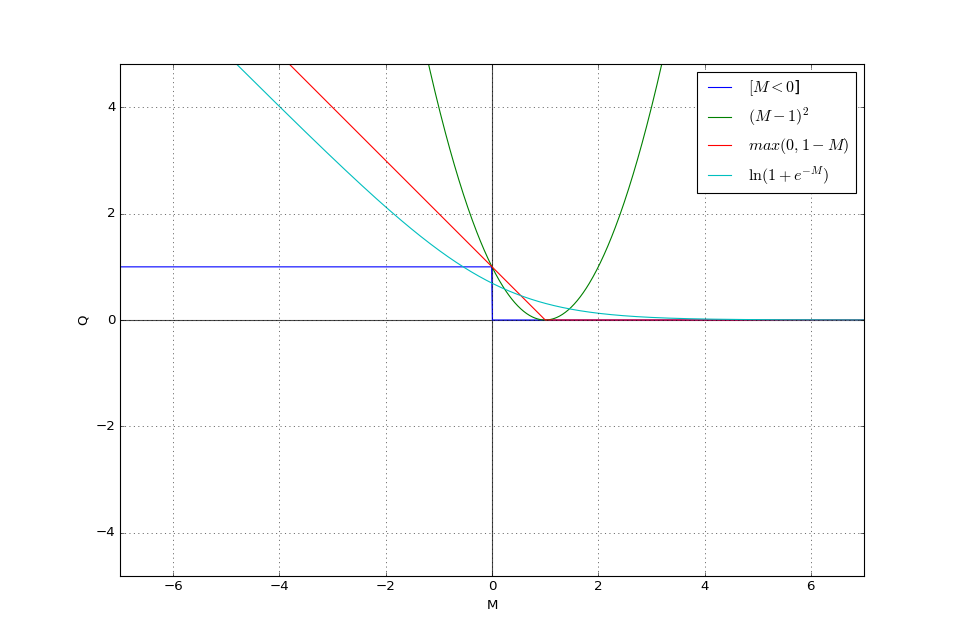

In [4]:
margin = np.linspace(-7, 7, 1000)


@np.vectorize
def exact_loss_m(x):
    return 1 if x < 0 else 0


@np.vectorize
def mse_loss_m(x):
    return (x - 1) ** 2


@np.vectorize
def hinge_loss_m(x):
    return max(0, 1 - x)


@np.vectorize
def logistic_loss_m(x):
    return np.log(1 + np.exp(-x))


setup_plot_figure('M', 'Q', True, True, True)
plt.plot(margin, exact_loss_m(margin), label='$[M<0$]')
plt.plot(margin, mse_loss_m(margin), label='$(M - 1)^2$')
plt.plot(margin, hinge_loss_m(margin), label='$max(0,1-M)$')
plt.plot(margin, logistic_loss_m(margin), label='$\ln(1+e^{-M})$')
plt.legend()
plt.xlim(-7, 7)
plt.ylim(-3, 3)
plt.show()

**Градиентный спуск**

In [5]:
def grad_descent(x0, func, grad, learn_rate, iter_num):
    steps = np.empty((iter_num, x0.shape[0]))
    costs = np.empty(iter_num)
    for i in range(iter_num):
        costs[i] = func(x0)
        steps[i] = x0
        x0 -= learn_rate * grad(x0)
    return x0, costs, steps

<IPython.core.display.Javascript object>


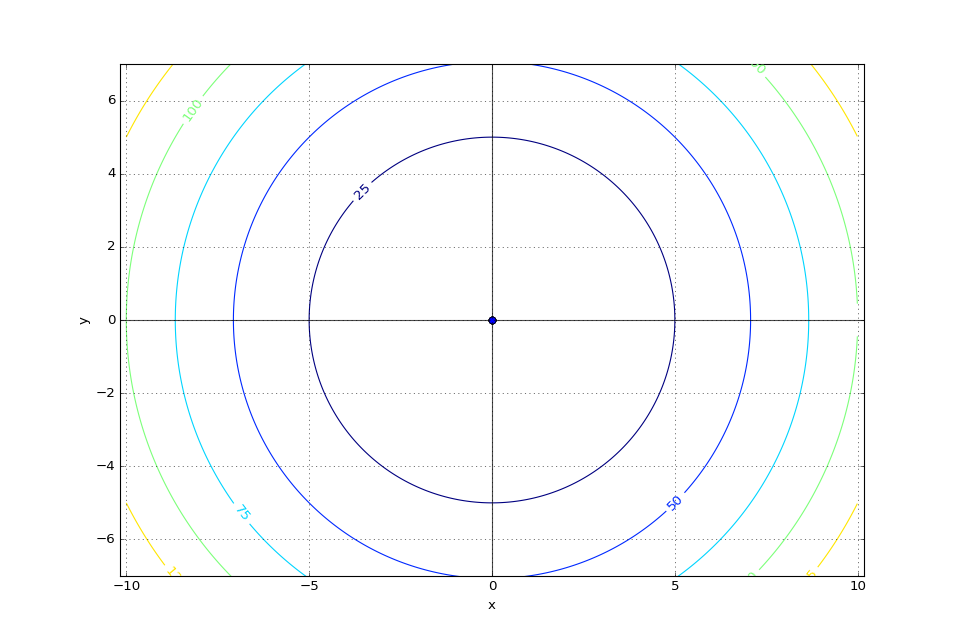

Optimal learning rate:  0.0271


In [6]:
def simple_func(x):  # z=x^2+y^2
    return x[0] ** 2 + x[1] ** 2


def simple_grad(x):
    return 2 * x


xx = np.arange(-10, 10, 0.01)
yy = np.arange(-10, 10, 0.01)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid = simple_func((xgrid, ygrid))
setup_plot_figure(hline=True, vline=True, equal_axes=True)
cont = plt.contour(xgrid, ygrid, zgrid)
plt.xlim(-10, 10)
plt.ylim(-7, 7)
cont.clabel(fmt="%.0f")

start_simple = np.random.randn(2) * 10
bestval_simple = simple_func(start_simple)
bestres = start_simple
bestlr = 0
for lr in np.arange(0, 1.5, 1e-4):
    res = grad_descent(start_simple, simple_func, simple_grad, lr, 50)
    if simple_func(res[0]) < bestval_simple:
        bestval_simple = simple_func(res[0])
        bestres = res[2]
        bestlr = lr
print('Optimal learning rate: ', bestlr)
plt.plot(bestres.T[0], bestres.T[1], 'bo')
plt.show()

1. Функция $z=x^2+y^2$, глобальный минимум $0$ в точке $(0;0)$.
2. См. ячейку выше.
3. См. ячейку выше.
4. См. ячейку выше.
5. Перебирались все значения $\lambda$ от 0 до 1.5 (при больших значениях градиент в некоторых случаях начинает значительно возрастать) с шагом в $10^{-4}$, при этом оптимизировалось значение функции в найденной точке. Логично, что оптимальная скорость обучения близка к 0.5, так как тогда за одну итерацию достигается $(x;y)-0.5\cdot(2x;2y)=(0;0)$ - глобальный минимум

Существуют функции, которые плохо даются градиентному спуску. К примеру, функция Розенброка

<center>$f(x, y) = (1-x)^2 + 100(y-x^2)^2$.</center>

<IPython.core.display.Javascript object>


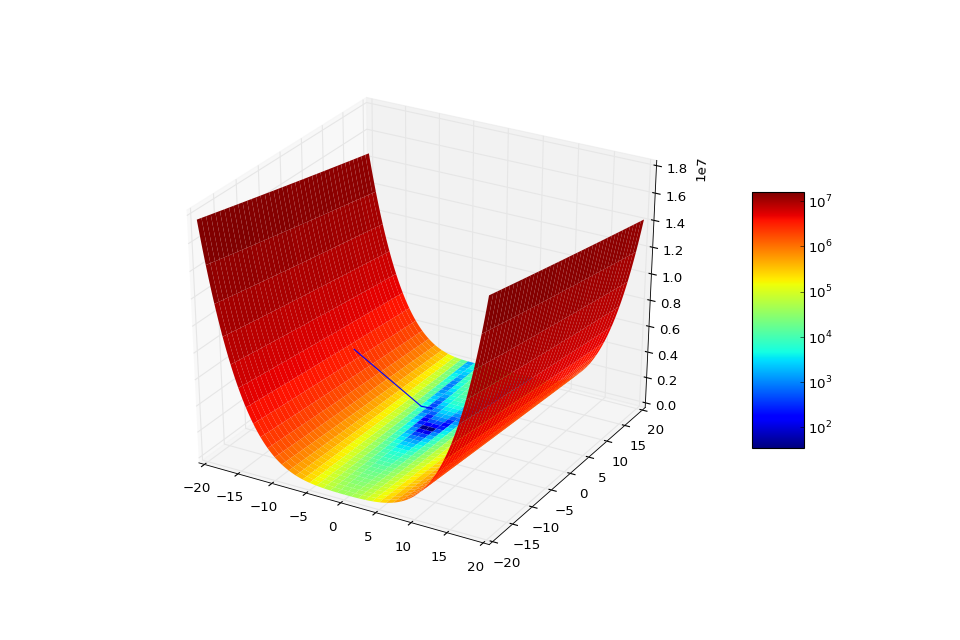

In [8]:
def rosenbrock(x):
    return (1 - x[0]) ** 2 + 100 * (x[1] - x[0] ** 2) ** 2


def rosenbrock_grad(x):
    return np.array([-2 * (1 - x[0]) - 400 * x[0] * (-x[0] ** 2 + x[1]), 200 * (-x[0] ** 2 + x[1])])


xx = np.arange(-20, 20, 0.1)
yy = np.arange(-20, 20, 0.1)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid = rosenbrock((xgrid, ygrid))
fig = setup_plot_figure()
ax = fig.gca(projection='3d')
cont = ax.plot_surface(xgrid, ygrid, zgrid, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet, linewidth=0, shade=False)
fig.colorbar(cont, shrink=0.5, aspect=5)
start_ros = np.random.randn(2) * 20
res_rosenbrock = grad_descent(start_ros, rosenbrock, rosenbrock_grad, 1e-5, 5000)[2]
z_ros = rosenbrock(res_rosenbrock.T)
ax.plot(xs=res_rosenbrock.T[0], ys=res_rosenbrock.T[1], zs=z_ros)
fig.show()

1. См. ячейку выше.
2. Можно заметить, что функция имеет участок с почти нулевым градиентом — «долину», но вне этой долины эта функция очень быстро растёт, поэтому при малых фиксированных $\lambda$ функция будет очень медленно сходиться, а при больших — расходиться, при этом градиент будет вновь быстро расти. Также в окрестности глобального минимума («долине») алгоритм будет двигаться в сторону глобального минимума очень медленно из-за близкого к нулю градиента.

3. Можно изменять скорость обучения динамически одним из множества способов, например, описанных ниже. Можно также стартовать алгоритм достаточно большое раз со случайными параметрами и затем выбрать лучший. Ещё есть вариант с нормализацией градиента (вообще говоря, длину также можно задавать), чтобы на каждой итерации мы двигались в направлении уменьшения функции, но одинаковыми шагами.

In [9]:
def mse_loss(w, x, y):
    return (1 / x.shape[0]) * np.sum((x.dot(w) - y) ** 2)


def mse_grad(w, x, y):
    return (2 / x.shape[0]) * x.T.dot(x.dot(w) - y)

<IPython.core.display.Javascript object>


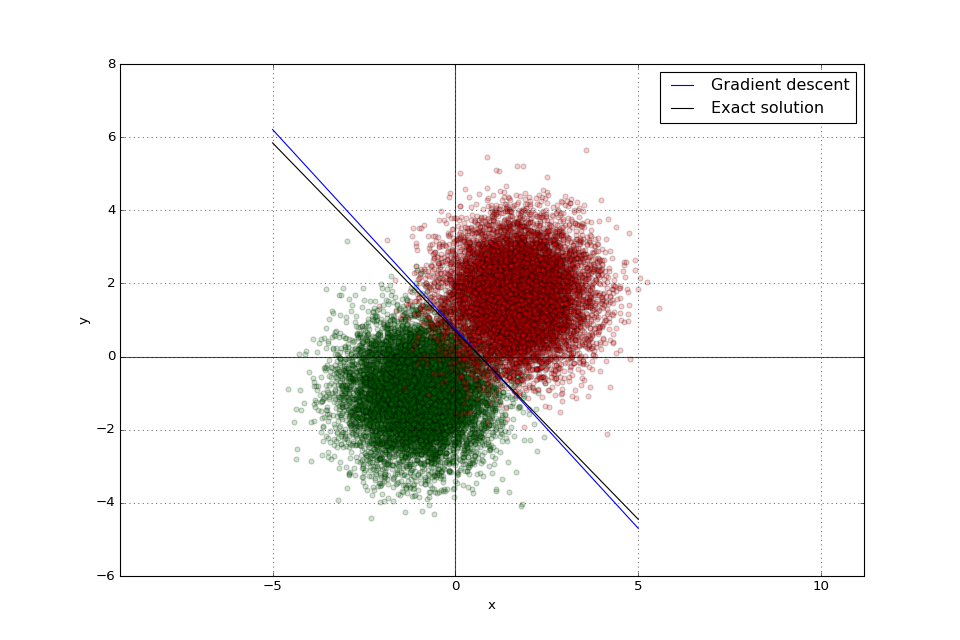

Difference between solutions norm: 0.0165594191144


In [18]:
start_2d = np.random.randn(3) * 10
sol_mse = grad_descent(start_2d, lambda w: mse_loss(w, X, Y), lambda w: mse_grad(w, X, Y), 0.01, 300)
yy = np.array(-(sol_mse[0][0] + sol_mse[0][1] * x_ax) / sol_mse[0][2])
setup_plot_figure(hline=True, vline=True, equal_axes=True)
plt.scatter(positive_class_features.T[0], positive_class_features.T[1], c='green', alpha=0.2)
plt.scatter(negative_class_features.T[0], negative_class_features.T[1], c='red', alpha=0.2)
plt.plot(x_ax, yy.T, color='b', label='Gradient descent')
plt.plot(x_ax, y_ax_exact.T, color='black', label='Exact solution')
plt.legend()
plt.show()
print('Difference between solutions norm:', np.linalg.norm(sol_mse[0] - w_exact))

**Метод наискорейшего спуска**

In [19]:
def grad_descent_accel(w, func, grad, iter_num):
    cur = w.copy()
    costs = np.empty(iter_num)
    steps = np.empty((iter_num, w.shape[0]))
    for i in range(iter_num):
        q = func(cur)
        costs[i] = q
        steps[i] = cur
        g = grad(cur)
        learn_rate = minimize(lambda l: func(cur - l * g), x0=np.zeros((1,))).x
        cur -= learn_rate * g
    return cur, costs, steps

<IPython.core.display.Javascript object>


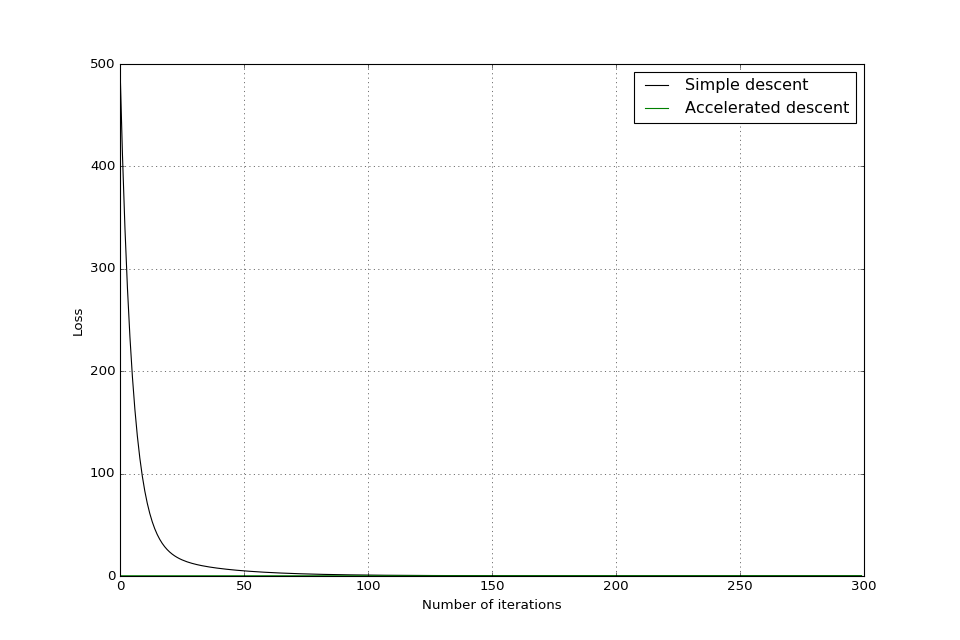

In [20]:
sol_mse_accel = grad_descent_accel(start_2d, lambda w: mse_loss(w, X, Y), lambda w: mse_grad(w, X, Y), 300)
setup_plot_figure('Number of iterations', 'Loss')
plt.plot(sol_mse[1], color='black', label='Simple descent')
plt.plot(sol_mse_accel[1], color='green', label='Accelerated descent')
plt.legend()
plt.show()

Из данного графика мы видим, что наискорейший спуск сходится значительно быстрее.

Если у нас есть какие-то признаки, которые встречаются достаточно редко, то соответствующий столбец будет разреженным.

**Задание**
В чем заключается проблема?

Так как в данном столбце будут преобладать нули, то градиент по соответствующей переменной на фоне остальных будет довольно мал, что означает в случае малой скорости обучения потенциально очень низкую скорость схождения ответа к оптимальному по данной переменной, а в случае большой - шанс расхождения по неразреженным столбцам. Более того, данные признаки могут быть значимыми при классификации, но из-за разреженности столбцов учитываться будут мало.

**Стохастический градиентный спуск**

In [21]:
def logistic_loss(w, x, y):
    return (1 / x.shape[0]) * sum(np.logaddexp(0, -y[i] * np.dot(x[i], w)) for i in range(x.shape[0]))


def logistic_grad(w, x, y):
    v = np.empty((x.shape[0], x.shape[1]))
    for i in range(x.shape[0]):
        val = -y[i] * np.dot(x[i], w)
        if np.abs(val) > 1000:  # overflow protection
            if val > 0:
                v[i] = -y[i] * x[i]
            else:
                v[i] = 0
        else:
            v[i] = -y[i] * x[i] * (math.exp(val) / (1 + math.exp(val)))
    return (1 / x.shape[0]) * np.sum(v, axis=0)

In [22]:
def sgd(w, x, y, func, grad, learn_rate, pass_num, batch_size=1):
    cur = w.copy()
    batch_num = x.shape[0] // batch_size
    costs = np.empty(pass_num * batch_num)
    steps = np.empty((pass_num * batch_num, w.shape[0]))
    for p in range(pass_num):
        for j in range(batch_num):
            x_new = x[j * batch_size:(j + 1) * batch_size]
            y_new = y[j * batch_size:(j + 1) * batch_size]
            costs[p * batch_num + j] = func(cur, x_new, y_new)
            steps[p * batch_num + j] = cur
            cur -= learn_rate * grad(cur, x_new, y_new)
    return cur, costs, steps

In [23]:
train = np.loadtxt('train.csv', skiprows=1, delimiter=',')
ones = train[train[:, 0] == 1]
zeroes = train[train[:, 0] == 0]
o_tr, o_test = np.split(ones, 2)  # training set is equal in size to test set
z_tr, z_test = np.split(zeroes, 2)
z_tr[:, 0] = 1  # we need first feature column to contain 1 in order for prediction to be fully vectorized;
#                 since b_size contains labels (0) in the original dataset, we can easily overwrite b_size after
#                 extracting labels
trainset = np.concatenate((o_tr, z_tr))
testset = np.concatenate((o_test, z_test))
labels = np.r_[np.ones(o_tr.shape[0]), -np.ones(z_tr.shape[0])].reshape(o_tr.shape[0] + z_tr.shape[0], 1)
testset_labels = list(map(lambda x: 1 if x == 1 else -1, testset[:, 0]))  # manually construct labels: 1 for 1, -1 for 0
testset[:, 0] = 1

In [24]:
start = np.zeros((train.shape[1]))
sol = sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 10, 4000)

In [25]:
def calculate_acc(w, test_features, test_labels):
    # 1st return value is number of wrong predictions, 2nd is accuracy (correct guesses/number of items in test set
    wrong = sum(np.sign(test_features[i].dot(w)) != test_labels[i] for i in range(test_features.shape[0]))
    return wrong, 1 - wrong / testset.shape[0]

In [26]:
calculate_acc(sol[0], testset, testset_labels)

(16, 0.99637023593466423)

<IPython.core.display.Javascript object>


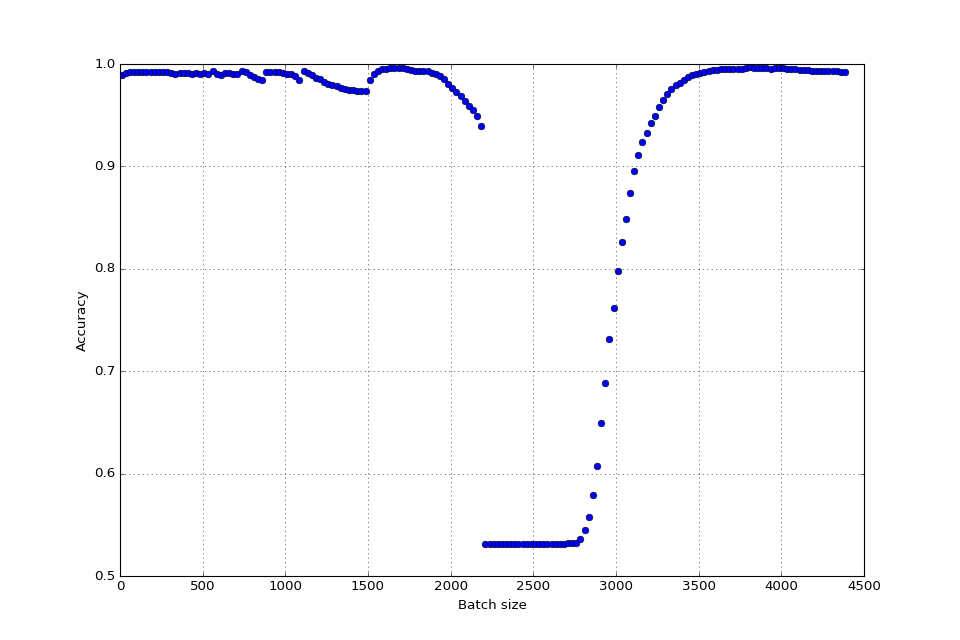

In [27]:
setup_plot_figure('Batch size', 'Accuracy')
for b_size in range(10, trainset.shape[0], 25):
    plt.plot(b_size,
             calculate_acc(sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 1, b_size)[0], testset,
                           testset_labels)[1], 'bo')
plt.show()

Заметим, что размер батчей не влияет на качество классификации заметным образом за исключением случая, когда выборка делится на два батча только с нулями и единицами (размер каждого - примерно 2000)

<IPython.core.display.Javascript object>


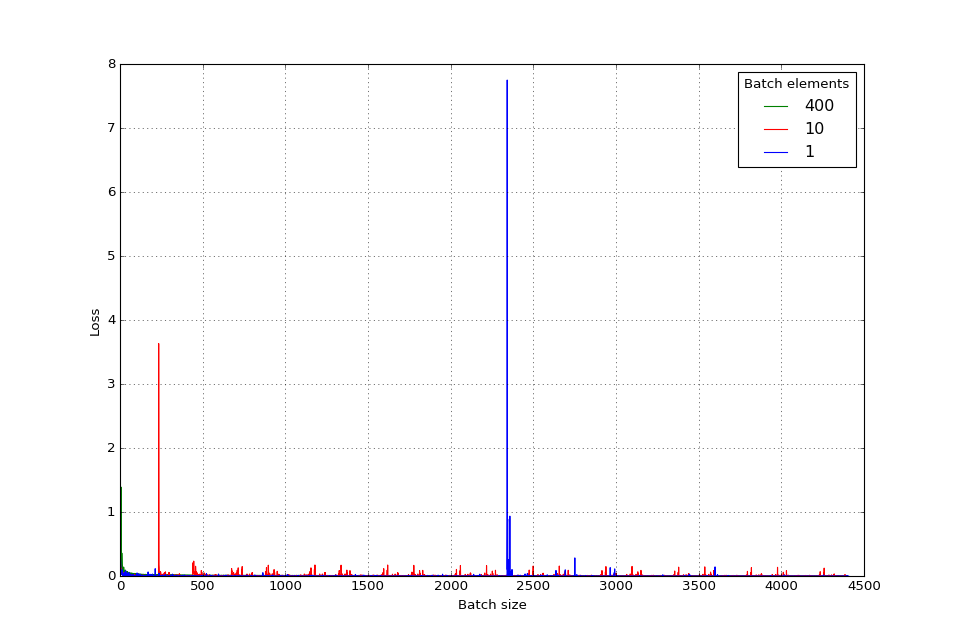

In [28]:
setup_plot_figure('Batch size', 'Loss')
plt.plot(sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 400, 400)[1], color='green', label='400')
plt.plot(sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 10, 10)[1], color='red', label='10')
plt.plot(sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 1)[1], color='blue', label='1')
plt.legend(title='Batch elements')
plt.show()

Такое число проходов для каждого размера батча мы ставим, чтобы в каждом случае алгоритм проработал одно и то же число итераций.
Можно заметить, что после ~4000 итерации графики функций (даже стохастического спуска) относительно стабилизируются, что может значить, что более 1 прохода даже в худшем случае по выборке делать смысла не так много.

**Экспоненциальное сглаживание**

In [29]:
def sgd_smooth(w, x, y, func, grad, learn_rate, pass_num, batch_size=1, gamma=0):
    cur = w.copy()
    batch_num = x.shape[0] // batch_size
    costs = np.empty(pass_num * batch_num)
    steps = np.empty((pass_num * batch_num, w.shape[0]))
    for p in range(pass_num):
        for j in range(batch_num):
            x_new = x[j * batch_size:(j + 1) * batch_size]
            y_new = y[j * batch_size:(j + 1) * batch_size]
            if p != 0 or j != 0:
                costs[p * batch_num + j] = gamma * costs[p * batch_num + j - 1] + (1 - gamma) * func(cur, x_new, y_new)
            else:
                costs[p * batch_num + j] = func(cur, x_new, y_new)
            steps[p * batch_num + j, :] = cur
            cur -= learn_rate * grad(cur, x_new, y_new)
    return cur, costs, steps

<IPython.core.display.Javascript object>


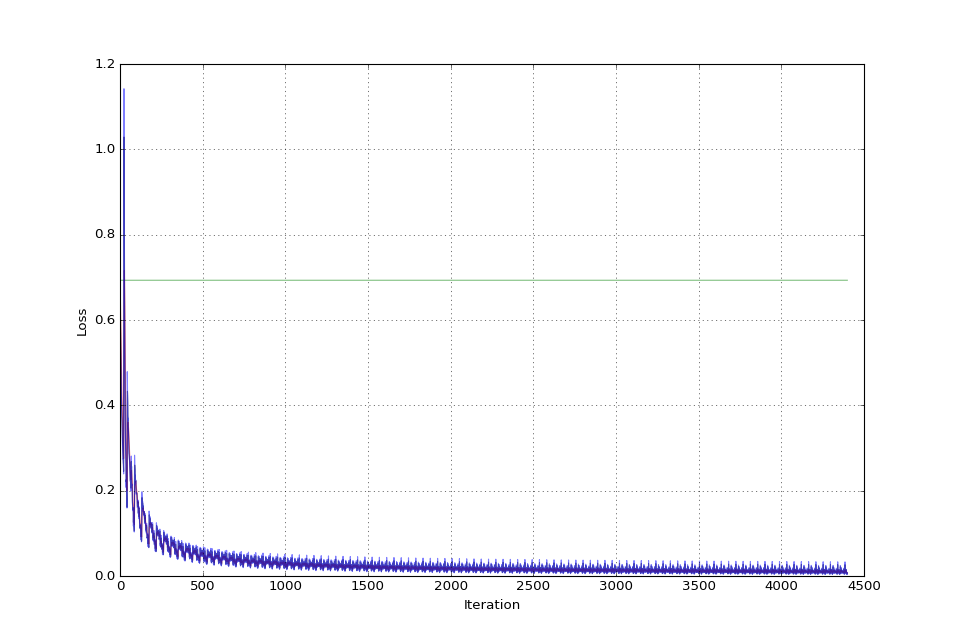

In [30]:
setup_plot_figure('Iteration', 'Loss')
plt.plot(sgd_smooth(start, trainset, labels, logistic_loss, logistic_grad, 1e-7, 100, 100, 1)[1], color='green',
         alpha=0.5)
plt.plot(sgd_smooth(start, trainset, labels, logistic_loss, logistic_grad, 1e-7, 100, 100, 0.75)[1], color='red',
         alpha=0.5)
plt.plot(sgd_smooth(start, trainset, labels, logistic_loss, logistic_grad, 1e-7, 100, 100, 0.25)[1], color='black',
         alpha=0.5)
plt.plot(sgd_smooth(start, trainset, labels, logistic_loss, logistic_grad, 1e-7, 100, 100)[1], color='blue', alpha=0.5)
plt.show()

Заметим, что в случае $\gamma=1$ функция ошибки вырождается в константное значение на первом батче первого прохода, в случае $\gamma=0$ - в функцию ошибки без сглаживания. Также можно рассмотреть конкретные $Q^k$ и $Q(x_{k+1})$, тогда после несложных преобразований получаем, что $Q^{k+1}$ - линейная функция от $\gamma$, пересекающая ось ординат в точке $Q(x_{k+1})$. Таким образом, $\gamma$ влияет на график функции ошибки следующим образом: последующие значение начинают "учитывать" предыдущие, таким образом, как и следует из названия, сглаживаются скачки функции ошибки при обработке стоящих друг за другом батчей. Наиболее подходящий способ вычисления $Q$ зависит от задачи: сглаживание может не всегда удовлетворять нашим нуждам (например, мы хотим с какой-то целью анализировать скачки в неизменном виде). 

**Сохранение импульса**

In [31]:
def grad_descent_momentum(w, func, grad, learn_rate, iter_num, gamma=0):
    cur = w.copy()
    steps = np.empty((iter_num, w.shape[0]))
    costs = np.empty(iter_num)
    momentum = np.zeros(w.shape[0])
    for i in range(iter_num):
        costs[i] = func(cur)
        momentum = gamma * momentum + learn_rate * grad(cur)
        cur -= momentum
        steps[i] = cur
    return cur, costs, steps

<IPython.core.display.Javascript object>


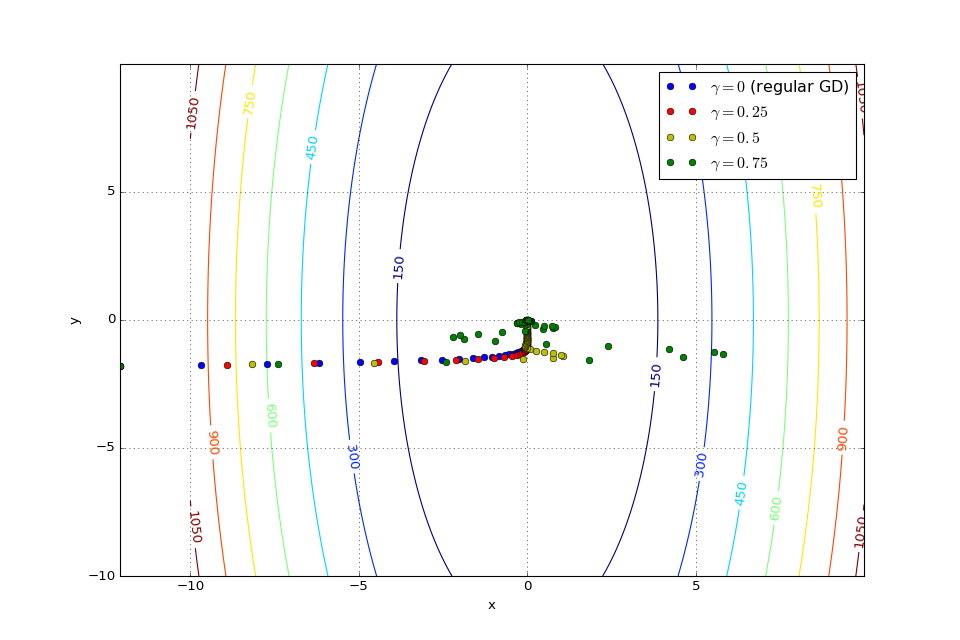

In [32]:
def simple1_func(x):  # z=10x^2+y^2
    return 10 * x[0] ** 2 + x[1] ** 2


def simple1_grad(x):
    return np.array([20 * x[0], 2 * x[1]])


xx = np.arange(-10, 10, 0.01)
yy = np.arange(-10, 10, 0.01)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid = simple1_func((xgrid, ygrid))
setup_plot_figure()
cont = plt.contour(xgrid, ygrid, zgrid)
cont.clabel(fmt="%.0f")

start_simple_1 = np.random.randn(2) * 10
res_without_momentum = grad_descent_momentum(start_simple_1, simple1_func, simple1_grad, 1e-2, 50)
plt.plot(res_without_momentum[2].T[0], res_without_momentum[2].T[1], 'bo', label='$\gamma=0$ (regular GD)')
res_with_momentum1 = grad_descent_momentum(start_simple_1, simple1_func, simple1_grad, 1e-2, 50, 0.25)
plt.plot(res_with_momentum1[2].T[0], res_with_momentum1[2].T[1], 'ro', label='$\gamma=0.25$')
res_with_momentum2 = grad_descent_momentum(start_simple_1, simple1_func, simple1_grad, 1e-2, 50, 0.5)
plt.plot(res_with_momentum2[2].T[0], res_with_momentum2[2].T[1], 'yo', label='$\gamma=0.5$')
res_with_momentum3 = grad_descent_momentum(start_simple_1, simple1_func, simple1_grad, 1e-2, 50, 0.75)
plt.plot(res_with_momentum3[2].T[0], res_with_momentum3[2].T[1], 'go', label='$\gamma=0.75$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


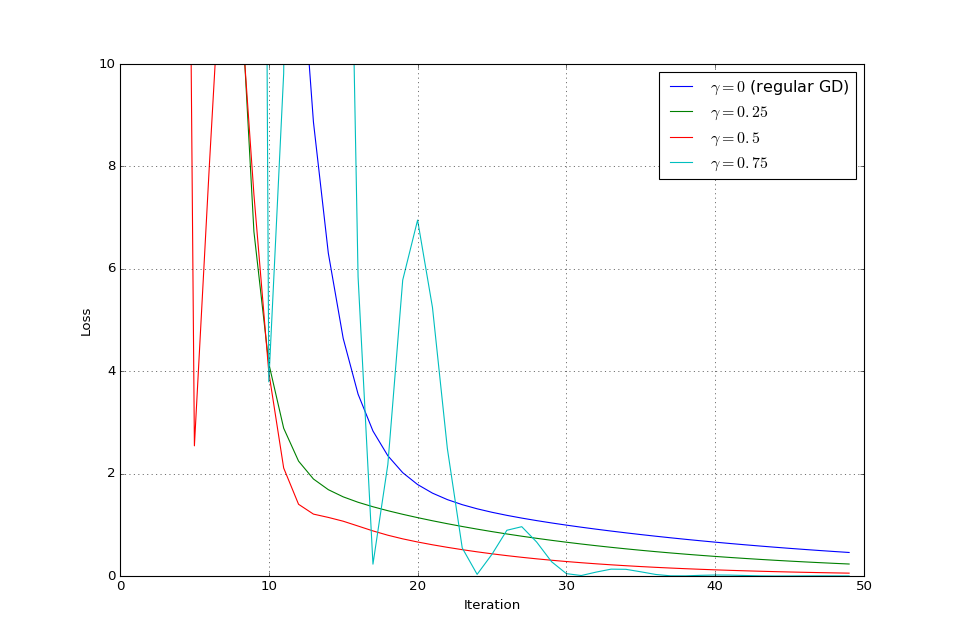

In [33]:
setup_plot_figure('Iteration', 'Loss')
plt.plot(res_without_momentum[1], label='$\gamma=0$ (regular GD)')
plt.plot(res_with_momentum1[1], label='$\gamma=0.25$')
plt.plot(res_with_momentum2[1], label='$\gamma=0.5$')
plt.plot(res_with_momentum3[1], label='$\gamma=0.75$')
plt.ylim(0, 10)
plt.legend()
plt.show()

Легко заметить, что повышение коэффициента на текущих данных и при фиксированных остальных параметрах даёт повышение скорости сходимости. Были рассмотрены 4 варианта $\gamma$, отстоящие от соседей на равных расстояниях, чтобы продемонстрировать динамику изменений графика в зависимости от данного параметра.

**Ускоренный градиент Нестерова**

In [34]:
def grad_descent_nesterov(w, func, grad, learn_rate, iter_num, gamma=0):
    cur = w.copy()
    steps = np.empty((iter_num, w.shape[0]))
    costs = np.empty(iter_num)
    momentum = np.zeros(w.shape[0])
    for i in range(iter_num):
        costs[i] = func(cur)
        momentum = gamma * momentum + learn_rate * grad(cur - momentum)
        cur -= momentum
        steps[i] = cur
    return cur, costs, steps

<IPython.core.display.Javascript object>


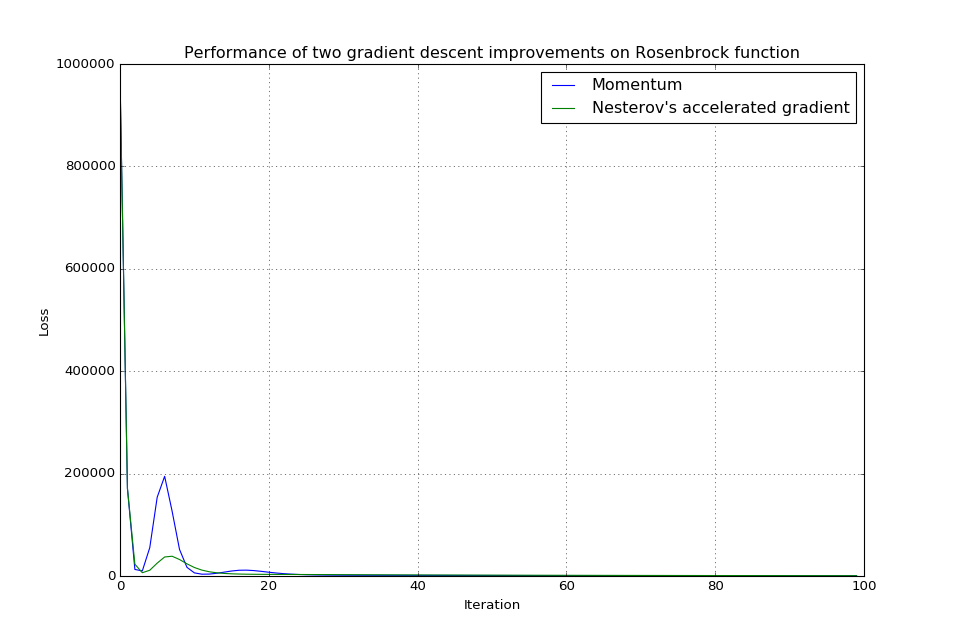

In [47]:
start_m = np.random.randn(2) * 10
res_imp = grad_descent_momentum(start_m, rosenbrock, rosenbrock_grad, 1e-5, 100, 0.8)
res_nes = grad_descent_nesterov(start_m, rosenbrock, rosenbrock_grad, 1e-5, 100, 0.8)
setup_plot_figure('Iteration', 'Loss')
plt.plot(res_imp[1], label='Momentum')
plt.plot(res_nes[1], label='Nesterov\'s accelerated gradient')
plt.title('Performance of two gradient descent improvements on Rosenbrock function')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


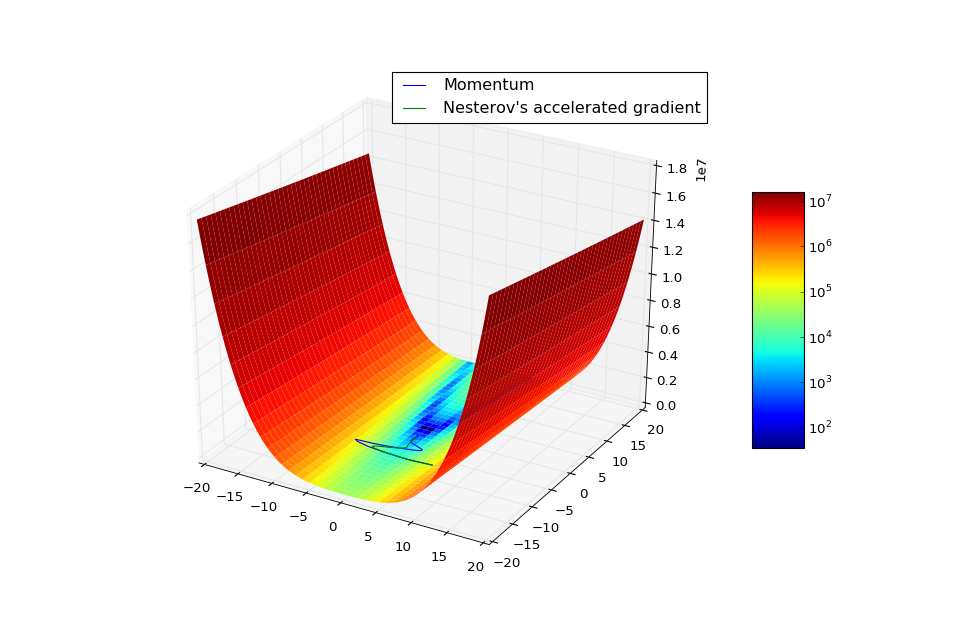

In [48]:
xx = np.arange(-20, 20, 0.1)
yy = np.arange(-20, 20, 0.1)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid = rosenbrock((xgrid, ygrid))
fig = setup_plot_figure()
ax = fig.gca(projection='3d')
cont = ax.plot_surface(xgrid, ygrid, zgrid, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet, linewidth=0, shade=False)
fig.colorbar(cont, shrink=0.5, aspect=5)
ax.plot(xs=res_imp[2].T[0], ys=res_imp[2].T[1], zs=rosenbrock(res_imp[2].T), label='Momentum')
ax.plot(xs=res_nes[2].T[0], ys=res_nes[2].T[1], zs=rosenbrock(res_nes[2].T), label='Nesterov\'s accelerated gradient')
plt.legend()
fig.show()

**Adagrad (2011)**

In [37]:
def adagrad(w, func, grad, learn_rate, iter_num):
    cur = w.copy()
    costs = np.empty(iter_num)
    steps = np.empty((iter_num, w.shape[0]))
    eps = 0.01
    g = np.zeros((w.shape[0], w.shape[0]))
    for i in range(iter_num):
        costs[i] = func(cur)
        steps[i] = cur
        gr = grad(cur)
        g += np.dot(gr.T, gr)
        cur -= learn_rate * gr / (np.sqrt(np.diag(g)) + eps)
    return cur, costs, steps

<IPython.core.display.Javascript object>


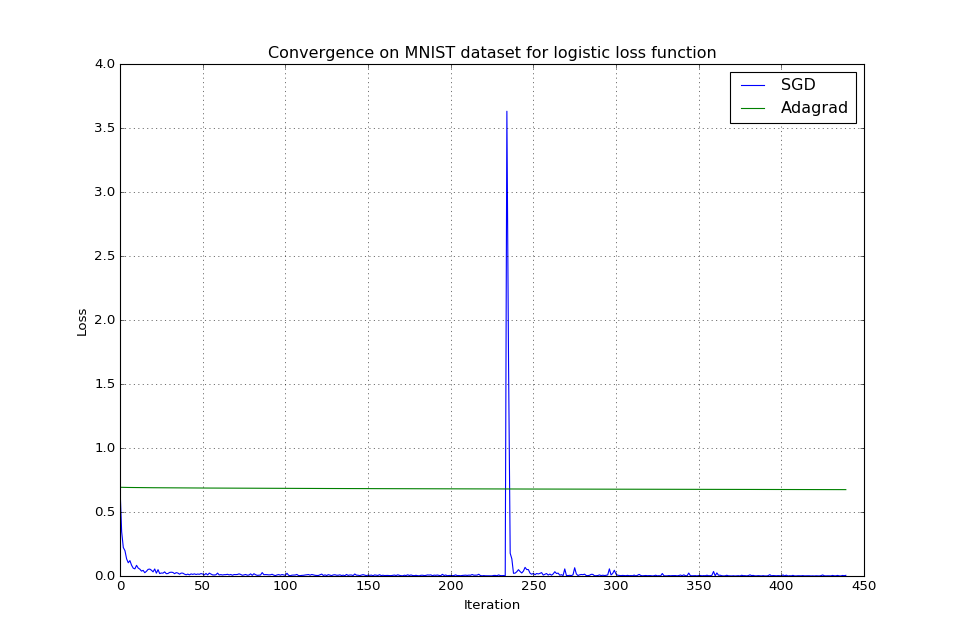

In [38]:
sol_sgd = sgd(start, trainset, labels, logistic_loss, logistic_grad, 1e-6, 1, 10)
sol_adagrad = adagrad(start, lambda w: logistic_loss(w, trainset, labels), lambda w: logistic_grad(w, trainset, labels),
                      1e-6, 440)
setup_plot_figure('Iteration', 'Loss')
plt.plot(sol_sgd[1], label='SGD')
plt.plot(sol_adagrad[1], label='Adagrad')
plt.legend()
plt.title('Convergence on MNIST dataset for logistic loss function')
plt.show()

**RMSprop**

In [39]:
def rmsprop(w, func, grad, learn_rate, iter_num, gamma=1):
    cur = w.copy()
    costs = np.empty(iter_num)
    steps = np.empty((iter_num, w.shape[0]))
    eps = 0.01
    g = np.zeros((w.shape[0], w.shape[0]))
    for i in range(iter_num):
        costs[i] = func(cur)
        steps[i] = cur
        gr = grad(cur)
        g = gamma * g + (1 - gamma) * np.dot(gr.T, gr)
        cur -= learn_rate * gr / (np.sqrt(np.diag(g)) + eps)
    return cur, costs, steps

**Adadelta (2012)**
1. В [статье](https://arxiv.org/pdf/1212.5701v1.pdf) главным преимуществом данного метода над обычным Adagrad называется целиком адаптивная скорость обучения (не нужно подбирать стартовый параметр) и избавление от проблемы уменьшения шага градиента при большом числе итераций (в матрице $G$ значения монотонно возрастают, так как добавляются квадраты компонент градиентов). Теперь дробь, определяющяя коэффициент перед градиентом для каждого шага, определяется следующим образом: $$\frac{RMS[\Delta w]_{t-1}}{RMS[g]_t}$$ $RMS[a]=\sqrt{E[a^2]+\varepsilon}$, $E[a^2]_t=\gamma E[a^2]_{t-1}+(1-\gamma)a_t^2$. Таким образом, мы подсчитываем на каждой итерации "средние квадратические" для градиентов и шагов, а затем на основании полученных результатов вычисляем новый шаг.
2. Выражение в знаменателе аналогично RMSprop, таким образом, всё, сказанное для него, остаётся истинным. Выражение в числителе добавляется для соответствия гипотетических "единиц измерения" $w$ и $\Delta w$ (по аналогии с методом Ньютона рассматриваем диагональ гессиана, чтобы размерности в итоговом выражении сошлись).

In [40]:
def adadelta(w, func, grad, iter_num, gamma=1):
    cur = w.copy()
    costs = np.empty(iter_num)
    steps = np.empty((iter_num, w.shape[0]))
    eps = 0.01
    dx = np.zeros((w.shape[0], w.shape[0]))
    g = np.zeros((w.shape[0], w.shape[0]))
    for i in range(iter_num):
        costs[i] = func(cur)
        steps[i] = cur
        gr = grad(cur)
        g = gamma * g + (1 - gamma) * np.dot(gr.T, gr)
        update = (np.sqrt(np.diag(dx)) + eps) * gr / (np.sqrt(np.diag(g)) + eps)
        dx = gamma * dx + (1 - gamma) * np.dot(update.T, update)
        cur -= update
    return cur, costs, steps

**Adam (2015)**

In [41]:
def adam(w, func, grad, learn_rate, iter_num, gamma=1):
    cur = w.copy()
    costs = np.empty(iter_num)
    steps = np.empty((iter_num, w.shape[0]))
    eps = 0.01
    g = np.zeros((w.shape[0], w.shape[0]))
    momentum = np.zeros((w.shape[0]))
    for i in range(iter_num):
        costs[i] = func(cur)
        steps[i] = cur
        gr = grad(cur)
        g = gamma * g + (1 - gamma) * np.dot(gr.T, gr)
        momentum = gamma * momentum + learn_rate * gr / (np.sqrt(np.diag(g)) + eps)
        cur -= momentum
    return cur, costs, steps

<IPython.core.display.Javascript object>


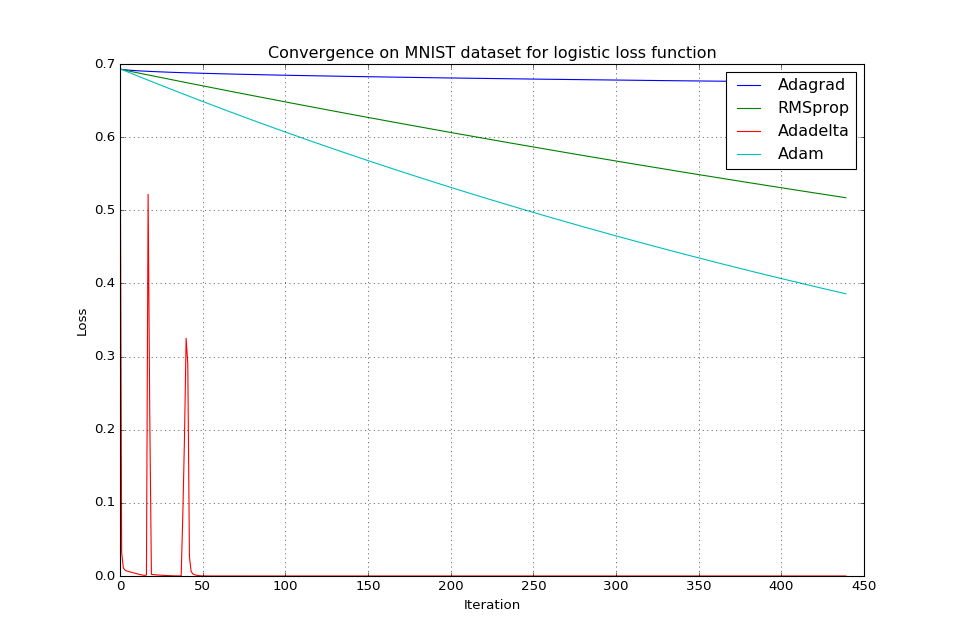

In [42]:
sol_rmsprop = rmsprop(start, lambda w: logistic_loss(w, trainset, labels), lambda w: logistic_grad(w, trainset, labels),
                      1e-6, 440, 0.5)
sol_adadelta = adadelta(start, lambda w: logistic_loss(w, trainset, labels),
                        lambda w: logistic_grad(w, trainset, labels), 440, 0.5)
sol_adam = adam(start, lambda w: logistic_loss(w, trainset, labels), lambda w: logistic_grad(w, trainset, labels), 1e-6,
                440, 0.5)

setup_plot_figure('Iteration', 'Loss')
plt.plot(sol_adagrad[1], label='Adagrad')
plt.plot(sol_rmsprop[1], label='RMSprop')
plt.plot(sol_adadelta[1], label='Adadelta')
plt.plot(sol_adam[1], label='Adam')
plt.legend()
plt.title('Convergence on MNIST dataset for logistic loss function')
plt.show()

Можно заметить, что скорость сходимости Adam по сравнению с методом сохранения импульса и RMSprop действительно повысилась, что можно обосновать тем, что алгоритм комбинирует в себе лучшее от двух неконфликтующих оптимизаций.

**Задание**
1. Предложите некоторую функцию, которая наглядно показывает отличие в работе всех предложенных методов.
2. Сделайте анимацию, которая пошагово отрисовывает треки все спусков.

В качестве функции-бенчмарка можно рассмотреть уже знакомую функцию Розенброка, так как её свойства позволят нам легко сравнить сходимости (в частности, в "долине").

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


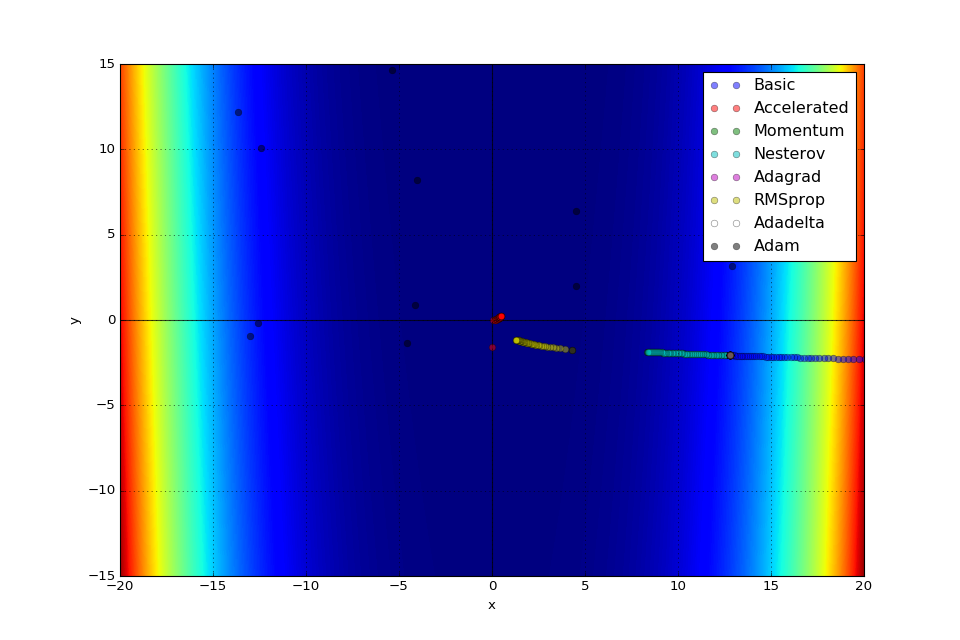

In [49]:
bench_start = np.random.randn(2) * 10
lr = 1e-7
iters = 50
bench_basic = grad_descent(bench_start, rosenbrock, rosenbrock_grad, lr, iters)[2]
bench_accel = grad_descent_accel(bench_start, rosenbrock, rosenbrock_grad, iters)[2]
bench_momentum = grad_descent_momentum(bench_start, rosenbrock, rosenbrock_grad, lr, iters, 0.5)[2]
bench_nesterov = grad_descent_nesterov(bench_start, rosenbrock, rosenbrock_grad, lr, iters, 0.5)[2]
bench_adagrad = adagrad(bench_start, rosenbrock, rosenbrock_grad, lr, iters)[2]
bench_rmsprop = rmsprop(bench_start, rosenbrock, rosenbrock_grad, lr, iters)[2]
bench_adadelta = adadelta(bench_start, rosenbrock, rosenbrock_grad, iters)[2]
bench_adam = adam(bench_start, rosenbrock, rosenbrock_grad, lr, iters)[2]
xx = np.arange(-20, 20, 0.01)
yy = np.arange(-20, 20, 0.01)
xgrid, ygrid = np.meshgrid(xx, yy)
zgrid = rosenbrock((xgrid, ygrid))
setup_plot_figure(hline=True, vline=True)
cont = plt.contourf(xgrid, ygrid, zgrid, 1000, cmap=plt.cm.jet)
plt.xlim(-20, 20)
plt.ylim(-15, 15)
plt.plot(bench_basic.T[0], bench_basic.T[1], 'bo', alpha=0.5, label='Basic')
plt.plot(bench_accel.T[0], bench_accel.T[1], 'ro', alpha=0.5, label='Accelerated')
plt.plot(bench_momentum.T[0], bench_momentum.T[1], 'go', alpha=0.5, label='Momentum')
plt.plot(bench_nesterov.T[0], bench_nesterov.T[1], 'co', alpha=0.5, label='Nesterov')
plt.plot(bench_adagrad.T[0], bench_adagrad.T[1], 'mo', alpha=0.5, label='Adagrad')
plt.plot(bench_rmsprop.T[0], bench_rmsprop.T[1], 'yo', alpha=0.5, label='RMSprop')
plt.plot(bench_adadelta.T[0], bench_adadelta.T[1], 'wo', alpha=0.5, label='Adadelta')
plt.plot(bench_adam.T[0], bench_adam.T[1], 'ko', alpha=0.5, label='Adam')
plt.legend()
plt.show()